## Machine learning modeling - Iteration #5


In [63]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import resample

In [64]:
# read in 990 data that has been
# with features already adjusted in 2nd iteration
df = pd.read_csv('data/990_model_data_2.csv')

In [65]:
df.shape

(26881, 28)

In [66]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299,188534687,170915216,17619471,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298,8,7,442,15.0,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176,12,12,139,50.0,2437,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


## Up-sample minority class to see if this improves model performance  

In [67]:
df_majority_class = df[df.TARGET_FEATURE == False]

In [68]:
# how many records are in the majority class?
df_majority_class.shape

(23972, 28)

In [69]:
df_minority_class = df[df.TARGET_FEATURE == True]

In [70]:
df_minority_class.shape

(2909, 28)

In [71]:
# upsample minority class
df_minority_upsampled = resample(df_minority_class,
                                replace=True,
                                n_samples=23972)

In [72]:
df_upsampled = pd.concat([df_majority_class, df_minority_upsampled])

In [73]:
# verify that I have the same number of records of each class
df_upsampled.TARGET_FEATURE.value_counts()

True     23972
False    23972
Name: TARGET_FEATURE, dtype: int64

In [74]:
# assign features
X = pd.get_dummies(df_upsampled).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df_upsampled.TARGET_FEATURE

In [75]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [76]:
# create model, check for overfitting
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=8)

cross_val_score(rfc, X, y, cv=5)

array([0.75109489, 0.7375391 , 0.72413433, 0.73925741, 0.74593242])

In [77]:
rfc.fit(X_train, y_train)

predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.08679442054490939
Percent Type II errors: 0.1544518315734585

Test set accuracy:
Percent Type I errors: 0.09208468036291584
Percent Type II errors: 0.16362498696422983


In [78]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,15837,3329
Actual: Yes,5924,13265


In [79]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,3923,883
Actual: Yes,1569,3214


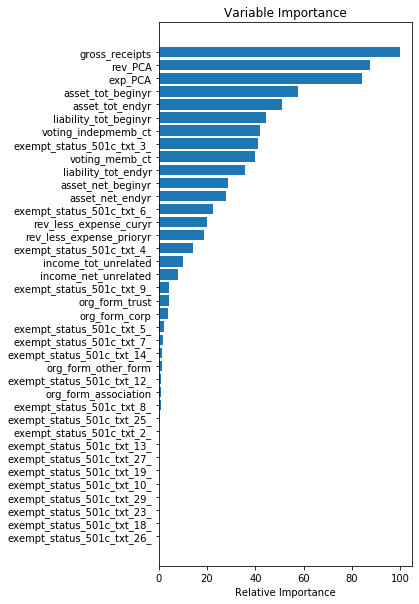

In [80]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');


### KNN Classifier

In [81]:
# fit model based on optimized parameters
knn_clf = KNeighborsClassifier(leaf_size= 1, n_neighbors= 110)

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [82]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [83]:
predict_train = knn_clf.predict(X_train)
predict_test = knn_clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.11654282362143137
Percent Type II errors: 0.1754138964932864

Test set accuracy:
Percent Type I errors: 0.12232766711857336
Percent Type II errors: 0.18604651162790697


In [84]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,14696,4470
Actual: Yes,6728,12461


In [85]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,3633,1173
Actual: Yes,1784,2999


### Gradient Boost Classifier

In [86]:
# Initialize and fit the model.
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
cross_val_score(clf, X2, y, cv=5)

array([0.87726799, 0.86047967, 0.85075094, 0.87213183, 0.86889862])

In [87]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.09174814235432147
Percent Type II errors: 0.11508277929865728

Test set accuracy:
Percent Type I errors: 0.10230472416310356
Percent Type II errors: 0.12879340911461049


In [88]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,15647,3519
Actual: Yes,4414,14775


In [89]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,3825,981
Actual: Yes,1235,3548


xxx

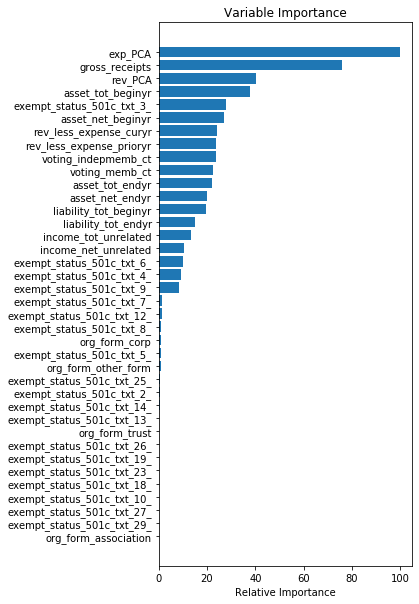

In [90]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [91]:
# find 10 most significant features
clf_features = pd.DataFrame(clf.feature_importances_,
            X.columns, columns=['importance']).sort_values(by='importance', ascending=False)

list(clf_features.head(10).index)

['exp_PCA',
 'gross_receipts',
 'rev_PCA',
 'asset_tot_beginyr',
 'exempt_status_501c_txt_3_',
 'asset_net_beginyr',
 'rev_less_expense_curyr',
 'rev_less_expense_prioryr',
 'voting_indepmemb_ct',
 'voting_memb_ct']